
================= Step 0 =================
👑 Leader 0 promotes with influence=0.30
🧍‍♀️ Consumer 20 | Leader 0 | Trust=0.85 | Sens=0.33 | Infl=0.30 | Prob=0.61 | Buy=True
🧍‍♀️ Consumer 22 | Leader 0 | Trust=0.54 | Sens=0.46 | Infl=0.30 | Prob=0.41 | Buy=False
🧍‍♀️ Consumer 17 | Leader 0 | Trust=0.69 | Sens=0.69 | Infl=0.30 | Prob=0.33 | Buy=False
🧍‍♀️ Consumer 7 | Leader 0 | Trust=0.82 | Sens=0.68 | Infl=0.30 | Prob=0.38 | Buy=False
🧍‍♀️ Consumer 21 | Leader 0 | Trust=0.61 | Sens=0.50 | Infl=0.30 | Prob=0.42 | Buy=True
🧍‍♀️ Consumer 10 | Leader 0 | Trust=0.90 | Sens=0.79 | Infl=0.30 | Prob=0.35 | Buy=False
🧍‍♀️ Consumer 1 | Leader 0 | Trust=0.64 | Sens=0.46 | Infl=0.30 | Prob=0.45 | Buy=True
🧍‍♀️ Consumer 26 | Leader 0 | Trust=0.63 | Sens=0.96 | Infl=0.30 | Prob=0.19 | Buy=False
🧍‍♀️ Consumer 23 | Leader 0 | Trust=0.55 | Sens=0.49 | Infl=0.30 | Prob=0.40 | Buy=False
🧍‍♀️ Consumer 24 | Leader 0 | Trust=0.82 | Sens=0.56 | Infl=0.30 | Prob=0.46 | Buy=True
🧍‍♀️ Consumer 12 | Leader 0 | Tr

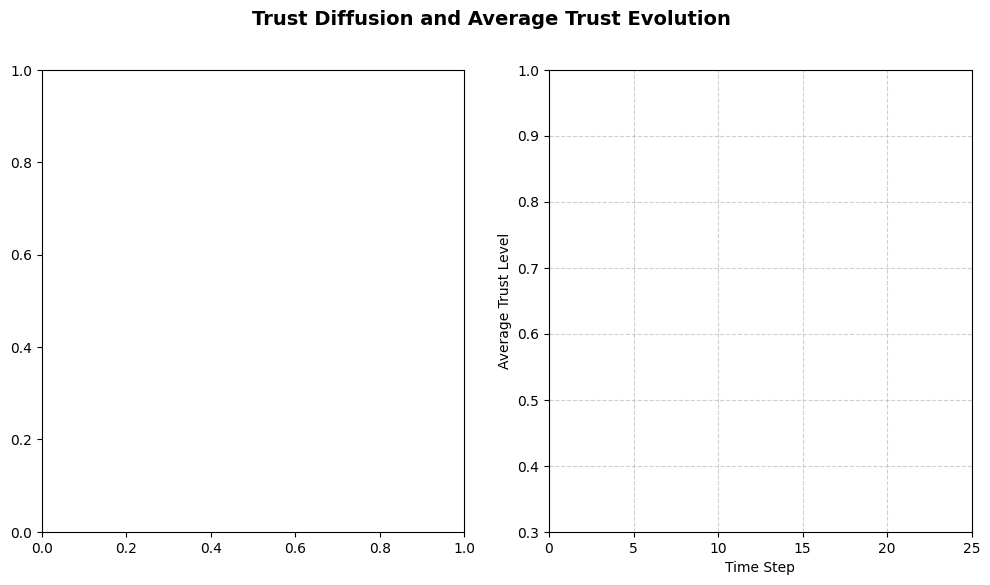

🎞️ Dual-view animation saved to: /Users/estherwang/Documents/GitHub/4403_project/data/trust_diffusion_dualview.gif


In [1]:
# Dual-View Animation: Trust Diffusion + Average Trust Evolution

import sys, os, random, numpy as np, matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import Normalize

# Import the group-buying ABM model from the project source directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from model import GroupBuyingModel

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Define a visualization subclass extending GroupBuyingModel
class VisualModel(GroupBuyingModel):
    """
    A subclass of GroupBuyingModel specifically designed for visualization.
    It tracks trust dynamics of consumers over time and captures average trust levels
    for animation and analysis.
    """

    def __init__(self, n_consumers=30, n_leaders=3):
        # Import core agent and scheduler classes
        from agents import Consumer, Leader, Platform
        from scheduler import SocialScheduler

        # Initialize model parameters
        self.n_consumers = n_consumers
        self.n_leaders = n_leaders

        # Initialize consumer agents:
        # Each consumer starts with a random trust level and price sensitivity.
        # Connections are simplified — each consumer is connected to all others for now.
        self.consumers = [
            Consumer(i, random.uniform(0.5, 1.0), random.uniform(0.3, 1.0), list(range(n_consumers)))
            for i in range(n_consumers)
        ]

        # Initialize leader agents:
        # Leaders have higher reputation values and randomly selected follower groups.
        self.leaders = [
            Leader(i, random.uniform(0.6, 1.0), random.sample(range(n_consumers), min(20, n_consumers)))
            for i in range(n_leaders)
        ]

        # Initialize the group-buying platform
        self.platform = Platform(base_price=5, subsidy=3)

        # SocialScheduler coordinates interactions between consumers, leaders, and platform
        self.scheduler = SocialScheduler(self.consumers, self.leaders, self.platform)

        # Initialize tracking lists
        # trust_snapshots stores consumer trust values at each time step
        # avg_trust records the system-wide average trust
        self.trust_snapshots = []
        self.avg_trust = []

    def step(self):
        """Perform a single time-step simulation and record trust metrics."""
        self.scheduler.step()
        trusts = [c.trust for c in self.consumers]
        self.trust_snapshots.append(trusts)
        self.avg_trust.append(np.mean(trusts))


# Run the model simulation for a predefined number of steps
model = VisualModel(n_consumers=30, n_leaders=3)
steps = 25
for _ in range(steps):
    model.step()

print(f"✅ Simulation finished with {steps} steps.")

# Build a static network graph layout for visualization

# Using Barabási–Albert model to generate a scale-free network of consumers
G = nx.barabasi_albert_graph(model.n_consumers, 2, seed=42)
pos = nx.spring_layout(G, seed=42)  # Fix layout positions for stable animation

leader_ids = [leader.id for leader in model.leaders]  # Record leader IDs
norm = Normalize(vmin=0.3, vmax=1.0)  # Normalization for color mapping (trust values)

# Create a dual-view figure layout: network view + trust evolution plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("Trust Diffusion and Average Trust Evolution", fontsize=14, fontweight='bold')

# Initialize the second subplot (average trust plot)
line, = ax2.plot([], [], color='crimson', linewidth=2)
ax2.set_xlim(0, steps)
ax2.set_ylim(0.3, 1.0)
ax2.set_xlabel("Time Step")
ax2.set_ylabel("Average Trust Level")
ax2.grid(True, linestyle='--', alpha=0.6)

# Animation update function — called once per frame
def update(frame):
    # Clear both axes for re-drawing
    ax1.clear()
    ax2.clear()

    # Retrieve trust values at the current frame
    trusts = model.trust_snapshots[frame]
    colors = plt.cm.plasma(norm(trusts))  # Map trust levels to color gradient

    # ---- Left plot: Trust diffusion network ----
    nx.draw_networkx_edges(G, pos, alpha=0.3, ax=ax1)

    # Draw consumer nodes (circles)
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[i for i in range(model.n_consumers) if i not in leader_ids],
        node_color=[colors[i] for i in range(model.n_consumers) if i not in leader_ids],
        node_size=150, ax=ax1
    )

    # Draw leader nodes (squares with black borders)
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=leader_ids,
        node_color=[colors[i] for i in leader_ids],
        node_shape='s', edgecolors='black', node_size=300, ax=ax1
    )

    ax1.set_title(f"Trust Diffusion Network — Step {frame+1}/{steps}")
    ax1.axis("off")

    # ---- Right plot: Average trust curve ----
    ax2.plot(range(frame+1), model.avg_trust[:frame+1], color='crimson', linewidth=2)
    ax2.set_xlim(0, steps)
    ax2.set_ylim(0.3, 1.0)
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Average Trust Level")
    ax2.set_title("Average Trust Over Time")
    ax2.grid(True, linestyle='--', alpha=0.6)


# Generate and preview animation
ani = FuncAnimation(fig, update, frames=len(model.trust_snapshots), interval=600, repeat=False)
plt.show()

# Save animation as a GIF file for presentation or documentation
save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'trust_diffusion_dualview.gif'))
os.makedirs(os.path.dirname(save_path), exist_ok=True)
ani.save(save_path, writer=PillowWriter(fps=2))
print(f"🎞️ Dual-view animation saved to: {save_path}")